# Evaluate likelihood ratio and posterior

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

from units import *
from simulation import SubhaloSimulator
from inference.inference import Estimator

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Test data

In [2]:
n_observations = 10

In [3]:
mass_base_unit = 1.e7 * M_s

alpha_true = 1000.
beta_true = -1.9

alpha_true, beta_true

(1000.0, -1.9)

In [4]:
sim = SubhaloSimulator(
    mass_base_unit=mass_base_unit,
    resolution=64,
    m_sub_min=100.,
)

img, latents = sim.rvs(alpha_true, beta_true, n_observations)

n_subs = np.array([v[0] for v in latents])
m_subs = [v[1] for v in latents]
pos_subs = [np.vstack((v[2], v[3])).T for v in latents]

14:46 simulation           INFO    Simulating image 1 / 10
14:46 simulation           INFO    Simulating image 2 / 10
14:46 simulation           INFO    Simulating image 3 / 10
14:46 simulation           INFO    Simulating image 4 / 10
14:46 simulation           INFO    Simulating image 5 / 10
14:46 simulation           INFO    Simulating image 6 / 10
14:46 simulation           INFO    Simulating image 7 / 10
14:46 simulation           INFO    Simulating image 8 / 10
14:46 simulation           INFO    Simulating image 9 / 10
14:46 simulation           INFO    Simulating image 10 / 10


## Evaluation

In [5]:
grid_res = 10

alpha_test = np.linspace(500., 1500., grid_res)
beta_test = np.linspace(-1.5, -2.3, grid_res)

theta0, theta1 = np.meshgrid(alpha_test, beta_test)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

In [6]:
re = Estimator()
re.load("../models/carl")

In [7]:
nllr, _ = re.evaluate_ratio(x=img, theta0=theta_grid)
nllr = -2. * nllr

## Plot

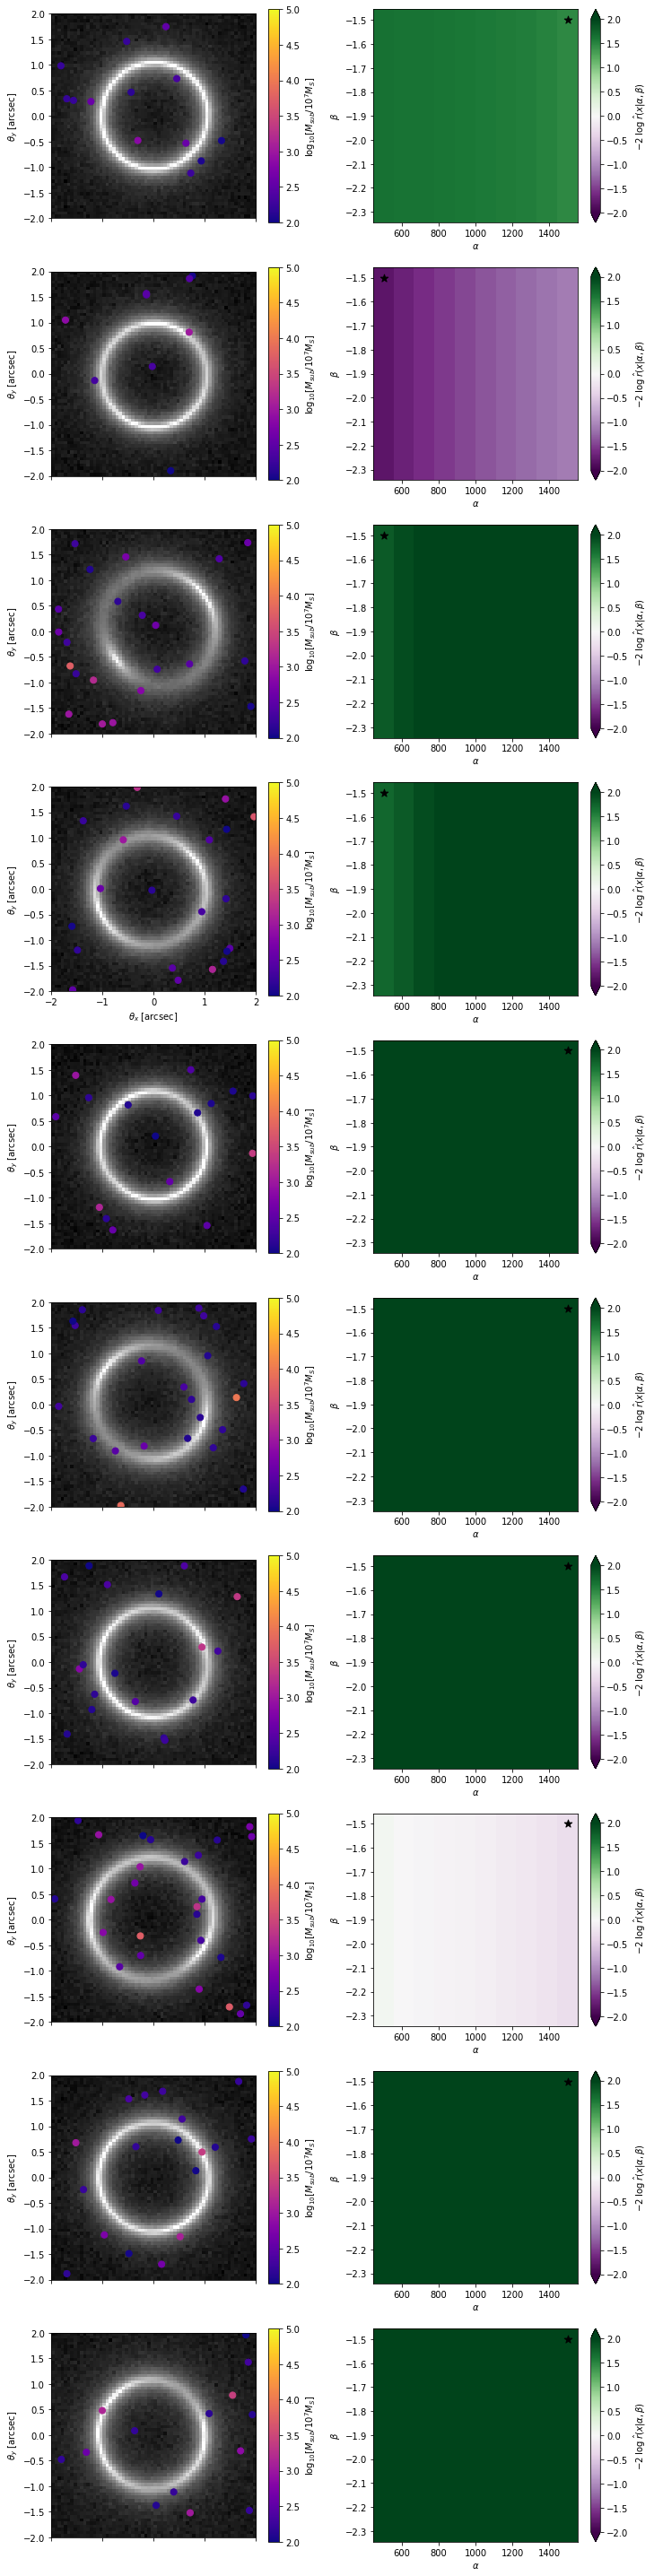

In [10]:
fig = plt.figure(figsize=(10, 4 * n_observations))

for i in [9,0,1,2,3,4,5,6,7,8]:
    
    # Plot image
    if i == 3:
        ax_left = plt.subplot(n_observations, 2, i*2+1)
        ax = ax_left
    else:
        ax = plt.subplot(n_observations, 2, i*2+1, sharex=ax_left)
    
    plt.imshow(
        np.log10(img[i]),
        vmax=3.5,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )
    sc = plt.scatter(
        pos_subs[i][:,0],
        pos_subs[i][:,1],
        s=50.,
        c=np.log10(m_subs[i][:]),
        cmap="plasma",
        vmin=2.,
        vmax=5.,
    )
    cbar = plt.colorbar(sc)
    
    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    
    if i == 3:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r"$\theta_y$ [arcsec]")
    cbar.set_label(r'$\log_{10} [M_{sub} / 10^7 M_S]$')
    
    
    
    # Plot estimated likelihood ratio for this image
    if i == 3:
        ax_right = plt.subplot(n_observations, 2, i*2+2)
        ax = ax_right
    else:
        ax = plt.subplot(n_observations, 2, i*2+2, sharex=ax_right)
        
    nllr_ = nllr[:, i]

    best_fit = theta_grid[np.argmin(nllr_)]
    cmin, cmax = -2., 2.  # np.min(nllr_), np.max(nllr_)

    bin_size = alpha_test[1] - alpha_test[0]
    alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
    bin_size = beta_test[1] - beta_test[0]
    beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        nllr_.reshape((grid_res, grid_res)),
        norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
        cmap='PRGn'
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'$-2\; \log \;\hat{r}(x | \alpha, \beta)$')

plt.tight_layout()
plt.savefig("carl_predictions.pdf")